In [1]:
# class3_text_classification_project.ipynb

# # Tugas Minggu ke-3: Proyek Klasifikasi Teks End-to-End
#
# ## Analisis Sentimen Review Film IMDB

In [24]:
# Untuk manipulasi data
import pandas as pd
import numpy as np

# Untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk preprocessing teks dan machine learning dari Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC # Contoh model tambahan
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Untuk interaksi dengan LLM (Google Gemini)
import google.generativeai as genai
from google.colab import userdata # Untuk API key management

# Untuk membersihkan teks (opsional, bisa disesuaikan)
import re
from bs4 import BeautifulSoup # Untuk menghapus tag HTML
import time

In [30]:
# Konfigurasi Kunci API (Untuk Penggunaan LLM)
# Kita akan menggunakan Google Colab Secrets untuk menyimpan Kunci API Gemini. Ini penting untuk keamanan dan praktik terbaik.

# ----------------------------------------------------------------
# 1.  Klik ikon "Kunci" (🔑) di sidebar kiri Colab.
# 2.  Klik "+ Add a new secret".
# 3.  Untuk "Name", masukkan `GEMINI_API_KEY`.
# 4.  Pada bagian "Value", tempel (paste) Kunci API Gemini kamu.
# 5.  Aktifkan "Notebook access".
# ----------------------------------------------------------------

In [4]:
try:
    GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
    if not GEMINI_API_KEY:
        raise ValueError("Kunci API 'GEMINI_API_KEY' tidak ditemukan di Colab Secrets.")
    genai.configure(api_key=GEMINI_API_KEY)
    print("Kunci API Gemini berhasil dikonfigurasi! 🎉")
except Exception as e:
    print(f"Error saat konfigurasi Kunci API: {e}")
    print("Pastikan kamu sudah mengatur 'GEMINI_API_KEY' di Colab Secrets jika ingin menggunakan LLM Gemini secara programatik.")
    GEMINI_API_KEY = None

Kunci API Gemini berhasil dikonfigurasi! 🎉


In [11]:
# Pastikan file "IMDB Dataset.csv" sudah di-upload ke Google Colab
# atau sesuaikan path jika disimpan di Google Drive.

try:
    # Mencoba dengan engine python yang lebih toleran
    df = pd.read_csv("IMDB Dataset.csv", engine='python')
    print("Dataset IMDB berhasil dimuat menggunakan engine Python!")
except Exception as e_python: # Menangkap error umum setelah mencoba engine python
    print(f"Gagal memuat dengan engine Python: {e_python}")
    print("Mencoba opsi lain: melewati baris yang bermasalah (on_bad_lines='skip')...")
    try:
        # Jika engine python gagal atau terlalu lambat, coba lewati baris error
        df = pd.read_csv("IMDB Dataset.csv", on_bad_lines='skip')
        print("Dataset IMDB berhasil dimuat dengan melewati baris bermasalah!")
    except FileNotFoundError:
        print("🚨 File 'IMDB Dataset.csv' tidak ditemukan. Pastikan file sudah di-upload dengan benar.")
        df = pd.DataFrame() # Buat dataframe kosong jika file tidak ditemukan
    except Exception as e_skip: # Menangkap error lain saat skip bad lines
        print(f"🚨 Gagal memuat dataset bahkan dengan on_bad_lines='skip': {e_skip}")
        print("Mohon periksa kembali file CSV Anda, mungkin ada kerusakan data yang cukup parah di sekitar baris 24515.")
        df = pd.DataFrame()
except FileNotFoundError:
    print("🚨 File 'IMDB Dataset.csv' tidak ditemukan. Pastikan file sudah di-upload dengan benar.")
    df = pd.DataFrame() # Buat dataframe kosong jika file tidak ditemukan


Dataset IMDB berhasil dimuat menggunakan engine Python!


Informasi Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   review             50000 non-null  object
 1   sentiment          50000 non-null  object
 2   cleaned_review     50000 non-null  object
 3   sentiment_numeric  50000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 1.5+ MB

5 Baris Pertama Dataset:


,review,sentiment,cleaned_review,sentiment_numeric
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production the filming tech...,1
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,negative,basically theres a family where a little boy j...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...,1



Distribusi Sentimen:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


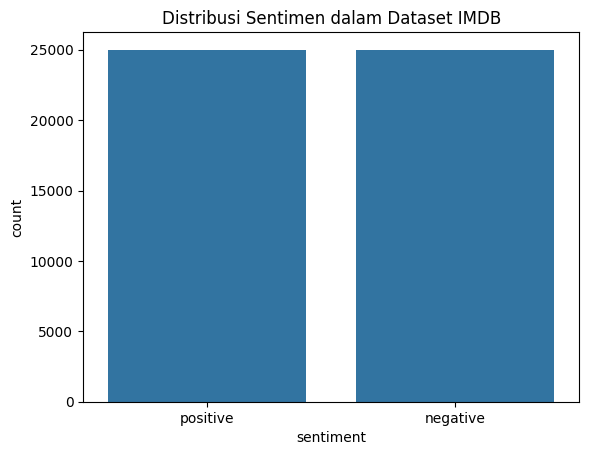

In [29]:
# Eksplorasi Awal Dataset

if not df.empty:
    print("Informasi Dataset:")
    df.info()
    print("\n5 Baris Pertama Dataset:")
    display(df.head())
    print("\nDistribusi Sentimen:")
    print(df['sentiment'].value_counts())
    # Visualisasi distribusi sentimen
    sns.countplot(x='sentiment', data=df)
    plt.title('Distribusi Sentimen dalam Dataset IMDB')
    plt.show()
else:
    print("Dataset kosong, tidak ada yang bisa dieksplorasi.")

In [13]:
# Teks review perlu dibersihkan sebelum digunakan untuk melatih model.

def preprocess_text(text):
    # Hapus tag HTML
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    # Hapus karakter non-alfabet (kecuali spasi) dan ubah ke lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    return text

if not df.empty:
    print("Memulai pra-pemrosesan teks...")
    # Buat kolom baru untuk teks yang sudah dibersihkan
    # Untuk dataset besar, df.apply bisa lambat. Pertimbangkan alternatif jika performa jadi isu.
    df['cleaned_review'] = df['review'].apply(preprocess_text)
    print("Pra-pemrosesan teks selesai.")
    print("\nContoh review setelah dibersihkan:")
    display(df[['review', 'cleaned_review', 'sentiment']].head())
else:
    print("Dataset kosong, pra-proses dilewati.")

Memulai pra-pemrosesan teks...
Pra-pemrosesan teks selesai.

Contoh review setelah dibersihkan:


,review,cleaned_review,sentiment
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming tech...,positive
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,basically theres a family where a little boy j...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter matteis love in the time of money is a ...,positive


In [14]:
if not df.empty:
    df['sentiment_numeric'] = df['sentiment'].map({'positive': 1, 'negative': 0})
    display(df[['sentiment', 'sentiment_numeric']].head())
else:
    print("Dataset kosong, pemetaan label dilewati.")

,sentiment,sentiment_numeric
0,positive,1
1,positive,1
2,positive,1
3,negative,0
4,positive,1


In [15]:
# Training dan Testing dari Data Asli

if not df.empty:
    X = df['cleaned_review']
    y = df['sentiment_numeric']

    # Bagi data menjadi 80% latih dan 20% uji
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    print(f"Ukuran data latih asli: {len(X_train_orig)}")
    print(f"Ukuran data uji asli: {len(X_test_orig)}")
else:
    print("Dataset kosong, pembagian data dilewati.")
    X_train_orig, X_test_orig, y_train_orig, y_test_orig = [], [], [], []

Ukuran data latih asli: 40000
Ukuran data uji asli: 10000


In [18]:
# Ubah teks menjadi numeric menggunakan TF-IDF

if 'X_train_orig' in locals() and not X_train_orig.empty:
    vectorizer = TfidfVectorizer(max_features=5000) # Batasi jumlah fitur untuk efisiensi

    X_train_vect = vectorizer.fit_transform(X_train_orig)
    X_test_vect = vectorizer.transform(X_test_orig)

    print("Dimensi matriks fitur data latih (TF-IDF):", X_train_vect.shape)
    print("Dimensi matriks fitur data uji (TF-IDF):", X_test_vect.shape)
else:
    print("Data latih asli (X_train_orig) kosong atau belum didefinisikan, vektorisasi dilewati.")
    X_train_vect, X_test_vect = None, None

Dimensi matriks fitur data latih (TF-IDF): (40000, 5000)
Dimensi matriks fitur data uji (TF-IDF): (10000, 5000)


In [21]:
# Train Model

models = {} # Dictionary untuk menyimpan model yang dilatih

if X_train_vect is not None and y_train_orig is not None and len(y_train_orig) > 0:
    # Model 1: Naive Bayes
    print("\nMelatih Model Naive Bayes...")
    nb_model = MultinomialNB()
    nb_model.fit(X_train_vect, y_train_orig)
    models['Naive Bayes'] = nb_model
    print("Model Naive Bayes selesai dilatih.")

    # Model 2: Logistic Regression
    print("\nMelatih Model Logistic Regression...")
    lr_model = LogisticRegression(solver='liblinear', random_state=42, max_iter=1000) # max_iter ditambah
    lr_model.fit(X_train_vect, y_train_orig)
    models['Logistic Regression'] = lr_model
    print("Model Logistic Regression selesai dilatih.")

else:
    print("Data latih tidak tersedia atau kosong, pelatihan model dilewati.")


Melatih Model Naive Bayes...
Model Naive Bayes selesai dilatih.

Melatih Model Logistic Regression...
Model Logistic Regression selesai dilatih.


In [22]:
# Evaluasi Model

if models and X_test_vect is not None and y_test_orig is not None and len(y_test_orig) > 0:
    print("\n--- Evaluasi Model pada Data Tes Asli ---")
    for model_name, model in models.items():
        y_pred_orig = model.predict(X_test_vect)
        accuracy_orig = accuracy_score(y_test_orig, y_pred_orig)
        print(f"\nModel: {model_name}")
        print(f"Akurasi pada data tes asli: {accuracy_orig:.4f}")
        print("Laporan Klasifikasi pada data tes asli:")
        print(classification_report(y_test_orig, y_pred_orig, target_names=['negative', 'positive']))
else:
    print("Model atau data tes asli tidak tersedia untuk evaluasi awal.")



--- Evaluasi Model pada Data Tes Asli ---

Model: Naive Bayes
Akurasi pada data tes asli: 0.8514
Laporan Klasifikasi pada data tes asli:
              precision    recall  f1-score   support

    negative       0.86      0.85      0.85      5000
    positive       0.85      0.86      0.85      5000

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


Model: Logistic Regression
Akurasi pada data tes asli: 0.8891
Laporan Klasifikasi pada data tes asli:
              precision    recall  f1-score   support

    negative       0.89      0.88      0.89      5000
    positive       0.88      0.90      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [32]:
def generate_llm_reviews(num_samples=5, target_sentiment="positif"):

    if not GEMINI_API_KEY:
        print("Kunci API Gemini tidak tersedia. Tidak dapat menghasilkan review.")
        return []

    try:
        llm_model = genai.GenerativeModel('gemini-1.5-flash-latest')
        prompt = f"""Tolong buatkan {num_samples} contoh review film singkat (sekitar 2-3 kalimat masing-masing).
Setiap review harus memiliki sentimen yang jelas: '{target_sentiment}'.
Pastikan review terdengar alami dan beragam.
Hanya berikan teks reviewnya saja, satu review per baris.

Contoh jika sentimen positif:
Film ini luar biasa! Aktingnya memukau dan ceritanya sangat menyentuh.
Sangat direkomendasikan, visualnya indah dan musiknya mendukung suasana.

Contoh jika sentimen negatif:
Benar-benar mengecewakan. Alurnya lambat dan membosankan.
Saya tidak menikmati film ini sama sekali, banyak plot hole.

Sekarang, buatkan untuk sentimen '{target_sentiment}':
"""
        print(f"Mengirim prompt ke LLM untuk {num_samples} review {target_sentiment}...")
        response = llm_model.generate_content(prompt)
        reviews = [review.strip() for review in response.text.split('\n') if review.strip()]
        return reviews[:num_samples] # Pastikan jumlahnya sesuai
    except Exception as e:
        print(f"Error saat menghasilkan review dengan LLM: {e}")
        return []

# Membuat 100 sampel: 50 positif, 50 negatif
num_samples_per_sentiment_llm = 50
llm_generated_reviews_positive = []
llm_generated_reviews_negative = []

if GEMINI_API_KEY: # Hanya jalankan jika API key ada
    print("\nMemulai pembuatan data tes dengan LLM (contoh programatik)...")
    llm_generated_reviews_positive = generate_llm_reviews(num_samples_per_sentiment_llm, "positif")
    print(f"Berhasil generate {len(llm_generated_reviews_positive)} review positif dari LLM.")
    time.sleep(5) # Jeda agar tidak overload API jika ada rate limit
    llm_generated_reviews_negative = generate_llm_reviews(num_samples_per_sentiment_llm, "negatif")
    print(f"Berhasil generate {len(llm_generated_reviews_negative)} review negatif dari LLM.")
else:
    print("\nSkipping programmatic LLM data generation: API key not configured.")
    print("ANDA HARUS MENGGUNAKAN LLM (WEB UI ATAU API) UNTUK MENGHASILKAN 100 DATA TES DAN MENDOKUMENTASIKAN INTERAKSI ANDA.")

# Gabungkan data dan buat DataFrame
llm_texts = llm_generated_reviews_positive + llm_generated_reviews_negative
llm_labels_text = ['positive'] * len(llm_generated_reviews_positive) + ['negative'] * len(llm_generated_reviews_negative)
llm_labels_numeric = [1] * len(llm_generated_reviews_positive) + [0] * len(llm_generated_reviews_negative)

if llm_texts:
    df_llm_test = pd.DataFrame({
        'review': llm_texts,
        'sentiment': llm_labels_text,
        'sentiment_numeric': llm_labels_numeric
    })
    print(f"\nTotal data tes dari LLM: {len(df_llm_test)}")
    if not df_llm_test.empty:
        display(df_llm_test.sample(min(5, len(df_llm_test)))) # Tampilkan sampel acak
else:
    print("\nTidak ada data tes yang berhasil dibuat oleh LLM secara programatik dalam demo ini.")
    df_llm_test = pd.DataFrame(columns=['review', 'sentiment', 'sentiment_numeric'])



Memulai pembuatan data tes dengan LLM (contoh programatik)...
Mengirim prompt ke LLM untuk 50 review positif...
Berhasil generate 48 review positif dari LLM.
Mengirim prompt ke LLM untuk 50 review negatif...
Berhasil generate 49 review negatif dari LLM.

Total data tes dari LLM: 97


,review,sentiment,sentiment_numeric
24,Plot twist-nya mengejutkan dan membuat saya te...,positive,1
34,Sebuah karya sinematografi yang indah dan memu...,positive,1
40,"Kisah yang unik dan menarik, tidak pernah saya...",positive,1
67,Saya merasa tertipu dengan trailernya. Film a...,negative,0
7,"Musiknya sangat pas dengan suasana film, menam...",positive,1


# Dokumentasi Interaksi dengan AI

# LLM yang Digunakan : Gemini 1.5 Flash

# Prompt

Tolong buatkan {num_samples} contoh review film singkat (sekitar 2-3 kalimat masing-masing). Setiap review harus memiliki sentimen yang jelas: '{target_sentiment}'.
Pastikan review terdengar alami dan beragam.
Hanya berikan teks reviewnya saja, satu review per baris.

Contoh jika sentimen positif:
Film ini luar biasa! Aktingnya memukau dan ceritanya sangat menyentuh.
Sangat direkomendasikan, visualnya indah dan musiknya mendukung suasana.

Contoh jika sentimen negatif:
Benar-benar mengecewakan. Alurnya lambat dan membosankan.
Saya tidak menikmati film ini sama sekali, banyak plot hole.

Sekarang, buatkan untuk sentimen '{target_sentiment}':

# Respons
Review	sentiment	sentiment_numeric

24	Plot twist-nya mengejutkan dan membuat saya te...	positive	1

34	Sebuah karya sinematografi yang indah dan memu...	positive	1

40	Kisah yang unik dan menarik, tidak pernah saya...	positive	1

67	Saya merasa tertipu dengan trailernya. Film a...	negative	0

7	Musiknya sangat pas dengan suasana film, menam...	positive	1

In [33]:
# Prediksi & Evaluasi Model

if not df_llm_test.empty:
    print("Memproses data tes buatan LLM...")
    df_llm_test['cleaned_review'] = df_llm_test['review'].apply(preprocess_text)

    # Vektorisasi menggunakan vectorizer yang sudah di-fit pada data latih asli
    if vectorizer: # Pastikan vectorizer sudah ada
        X_llm_test_vect = vectorizer.transform(df_llm_test['cleaned_review'])
        y_llm_test = df_llm_test['sentiment_numeric']
        print(f"Data tes LLM siap untuk evaluasi. Ukuran: {X_llm_test_vect.shape}")
    else:
        print("Vectorizer belum diinisialisasi. Tidak bisa memproses data tes LLM.")
        X_llm_test_vect, y_llm_test = None, None
else:
    print("Dataset tes buatan LLM kosong. Evaluasi dilewati.")
    X_llm_test_vect, y_llm_test = None, None

Memproses data tes buatan LLM...
Data tes LLM siap untuk evaluasi. Ukuran: (97, 5000)


In [34]:
# Akurasi

llm_test_accuracies = {}

if models and X_llm_test_vect is not None and y_llm_test is not None and not y_llm_test.empty:
    print("\n--- Evaluasi Model pada Data Tes Buatan AI ---")
    for model_name, model in models.items():
        y_pred_llm = model.predict(X_llm_test_vect)
        accuracy_llm = accuracy_score(y_llm_test, y_pred_llm)
        llm_test_accuracies[model_name] = accuracy_llm
        print(f"\nModel: {model_name}")
        print(f"Akurasi pada data tes LLM: {accuracy_llm:.4f}")
        # Anda bisa juga menampilkan classification report di sini jika mau
        # print(classification_report(y_llm_test, y_pred_llm, target_names=['negative', 'positive']))
else:
    print("Model atau data tes LLM tidak tersedia untuk evaluasi.")


--- Evaluasi Model pada Data Tes Buatan AI ---

Model: Naive Bayes
Akurasi pada data tes LLM: 0.5464

Model: Logistic Regression
Akurasi pada data tes LLM: 0.5258



--- Tabel Akurasi Model pada Data Tes Buatan AI ---


,Model,Akurasi pada Data Tes LLM
0,Naive Bayes,0.546392
1,Logistic Regression,0.525773


<ipython-input-35-7118724c3b7b>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Akurasi pada Data Tes LLM', y='Model', data=df_accuracies, palette='viridis')


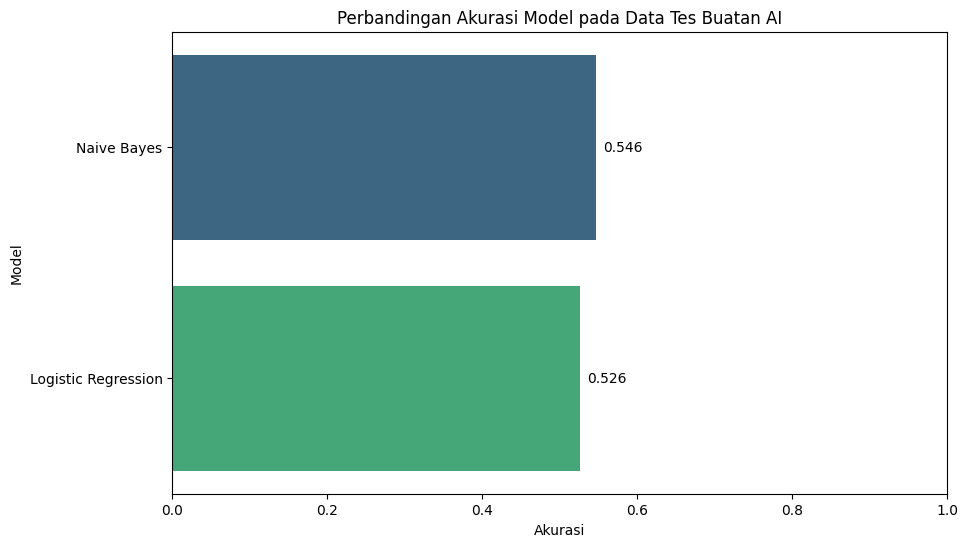

In [35]:
if llm_test_accuracies:
    df_accuracies = pd.DataFrame(list(llm_test_accuracies.items()), columns=['Model', 'Akurasi pada Data Tes LLM'])
    df_accuracies = df_accuracies.sort_values(by='Akurasi pada Data Tes LLM', ascending=False)

    print("\n--- Tabel Akurasi Model pada Data Tes Buatan AI ---")
    display(df_accuracies)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Akurasi pada Data Tes LLM', y='Model', data=df_accuracies, palette='viridis')
    plt.xlabel('Akurasi')
    plt.ylabel('Model')
    plt.title('Perbandingan Akurasi Model pada Data Tes Buatan AI')
    plt.xlim(0, 1.0) # Skala akurasi dari 0 sampai 1
    # Menambahkan teks akurasi pada bar
    for index, row in df_accuracies.iterrows():
        plt.text(row['Akurasi pada Data Tes LLM'] + 0.01, index, f"{row['Akurasi pada Data Tes LLM']:.3f}", color='black', ha="left", va="center")
    plt.show()
else:
    print("Tidak ada data akurasi untuk ditampilkan/diplot.")